# Свёртки

Начнём с того, что пощупаем свёртки руками, без PyTorch. Воспользуемся для этого более низкоуровневым пакетом OpenCV, который можно импортировать как `cv2`.

In [ ]:
import io
import numpy as np
import requests

from PIL import Image
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Слово о тензорах и картинках

Подгрузим какую-нибудь фотографию.

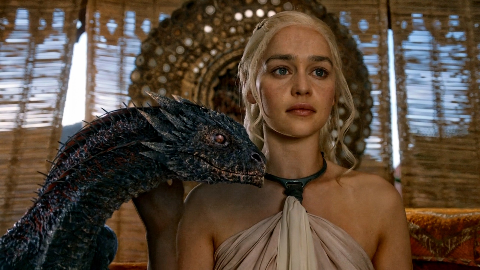

In [ ]:
def url_to_image(url):
    response = requests.get(url)  # Делаем HTTP GET запрос на адрес
    image = Image.open(io.BytesIO(response.content))  # Читаем ответ как картинку библиотекой PIL
    image = np.asarray(image)  # Конвертируем PIL Image в numpy array
    return image

def show_image(image):
    return Image.fromarray(image)

image_url = 'https://www.mirf.ru/wp-content/uploads/2017/01/Drakarys.jpg'
img = url_to_image(image_url)

# Для наших экспериментов мы уменьшим размер картинки, потому что
# в исходном качестве она занимает слишком много места на экране
img = cv2.resize(img, (0, 0), fx=1 / 4, fy=1 / 4, interpolation=cv2.INTER_CUBIC)

show_image(img)

Цветная картинка — это трёхмерный массив размерности `(высота, ширина, 3)`. Если мы попробуем такую картинку напечатать, то напечатается набор чисел. Каждому пикселю в такой картинке соответствуют 3 числа. Эти числа соответствуют яркостям красной (red), зелёной (green) и синей (blue) компоненты этого пикселя и меняются от 0 до 255. Такой формат записи цветов называется RGB. Бывают и другие форматы.

In [ ]:
img.shape  # 270 строк, 480 столбцов, 3 цветовых канала

(270, 480, 3)

In [ ]:
img[200, 100]  # значения трёх каналов пикселя в 200-й строке и 100-м столбце

array([13, 18, 11], dtype=uint8)

In [ ]:
img[0][:5]  # цвета 5 пикселей в верхней строке по шкале RGB

array([[59, 33,  6],
       [57, 32,  4],
       [54, 30,  3],
       [53, 30,  0],
       [48, 27,  0]], dtype=uint8)

In [ ]:
img[2]  # цвета пикселей в строке 2

array([[65, 40,  9],
       [60, 36,  5],
       [60, 36,  8],
       ...,
       [26, 12,  0],
       [23, 11,  0],
       [23, 11,  0]], dtype=uint8)

Можно прибавить какое-нибудь число ко всем пикселям:

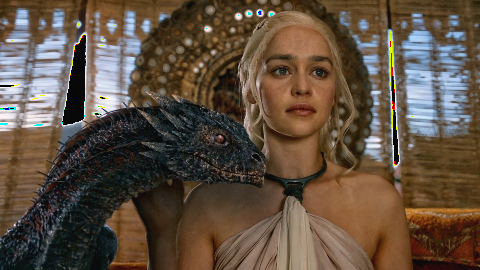

In [ ]:
show_image(img + 10)

Но появляются артефакты. Почему?

Дело в том, что картинка хранится с типом чисел `np.uint8`. Это означает, что каждое значение яркости компоненты RGB не только принимает значения только от 0 до 255, но и все арифметические операции с ними не смогут выходить за этот диапазон:

In [ ]:
print(img[0, 0])
print(img[0, 0] + 200)

[59 33  6]
[  3 233 206]


Если попробовать прибавить какое-нибудь большое число — например, 200 — ко всем значениям пикселей, то получится что-то странное:

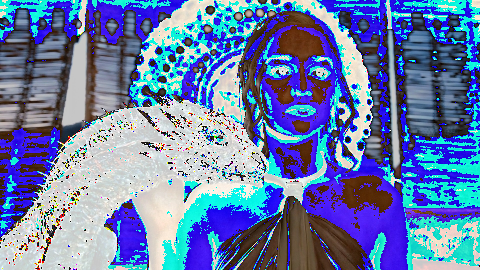

In [ ]:
show_image(img + 200)

Такие же спецэффекты будут и с умножением:

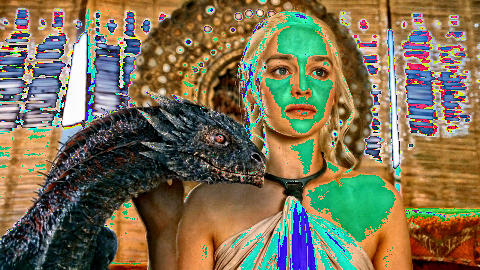

In [ ]:
show_image(img * 2)

Если попытаться умножить число типа `np.uint8` на дробное число, то получится `np.float64`:

In [ ]:
print(img[0, 0] * 0.7)
print((img[0, 0] * 0.7).dtype)

[41.3 23.1  4.2]
float64


Но его можно округлить обратно до `np.uint8`:

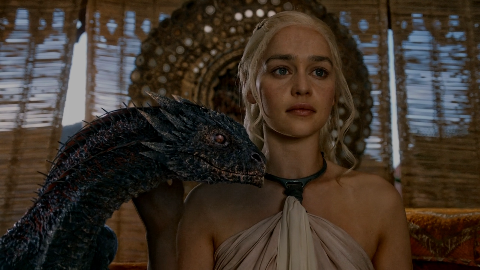

In [ ]:
show_image((img * 0.7).astype(np.uint8))

Можно посмотреть на то, как распределены на картинке пиксели различной яркости.

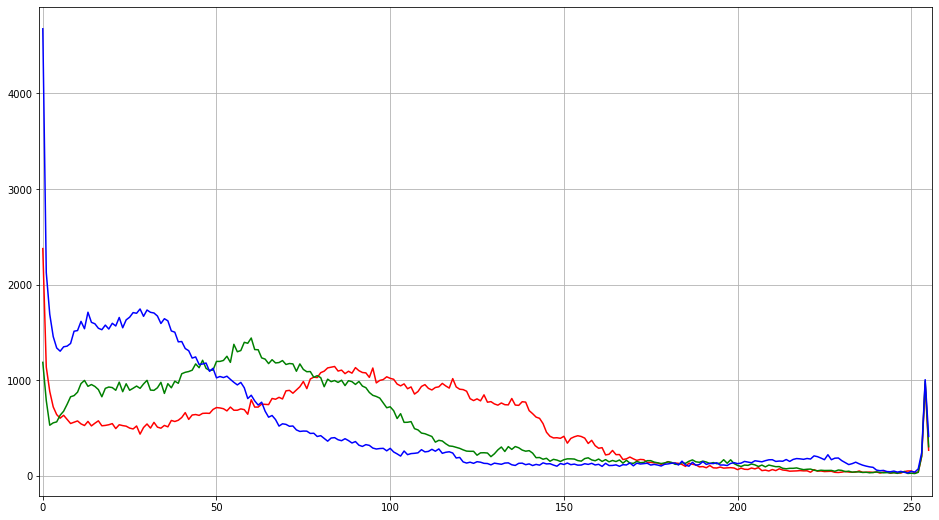

In [ ]:
from collections import Counter

plt.figure(figsize=(16, 9))

for i, color in enumerate('rgb'):
    # Вытаскиваем из картинки один канал
    channel = img[:, :, i]
    # Собираем dict, где ключи — значения интенсивности пикселей, а значения — сколько раз они встречаются
    cnt = Counter(channel.reshape(-1))
    # Преобразуем dict в список
    hist = [cnt[j] for j in range(256)]
    # Отрисовываем его
    plt.plot(hist, color=color)

plt.xlim(-1, 256)
plt.grid()

## 2. Свёртки

Свёртка — это операция, которая превращает набор одних пикселей в другие. Обычно она осущствляется с помощью ядра свёртки, матрицы произвольного размера (часто $3 \times 3$). Центральный элемент такой матрицы называется якорем свёртки. Удобно представлять себе, что он применяется к центральному пикселю. 

Работает свёртка очень просто. При вычислении нового значения выбранного пикселя изображения ядро свёртки прикладывается своим центром к этому пикселю. Далее вычисляется сумма произведений значений пикселей изображения на значения, накрывшего данный пиксель элемента ядра. Полученная сумма и является новым значением выбранного пикселя.

<center>
<img src="https://github.com/FUlyankin/neural_nets_dpo/raw/e296fc12d4b3a7c523728feec5f56c59b6b35633/week08_conv/convolution_schematic.gif">
</center>

Используя матрицы с разными коэффициентами, можно получать разные эффекты. 

Дальше нам понадобится вспомогательная функция для отображения нескольких картинок вплотную друг к другу.

In [ ]:
def show_multiple_images(images, figsize=(15, 12)):
    f, axarr = plt.subplots(1, len(images), figsize=figsize)
    for i, (title, image) in enumerate(images.items()):
        assert image.dtype == np.uint8, 'Please cast your images to np.uint8'
        if len(image.shape) == 3 and image.shape[2] == 1:
            image = image.squeeze(2)
        assert len(image.shape) in {2, 3}, 'Please ensure that your images are either black & white or RGB'
        if len(image.shape) == 3:
            axarr[i].imshow(image)
        else:
            axarr[i].imshow(image, cmap='gray')
        axarr[i].set_title(title)
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
    f.tight_layout()

Начнём с тривиального эффекта. Попробуем применить такое ядро:

$$ K = \begin{pmatrix}
0 & 0 & 0  \\
0 & 0.7 & 0 \\         
0 & 0 & 0 
\end{pmatrix} $$

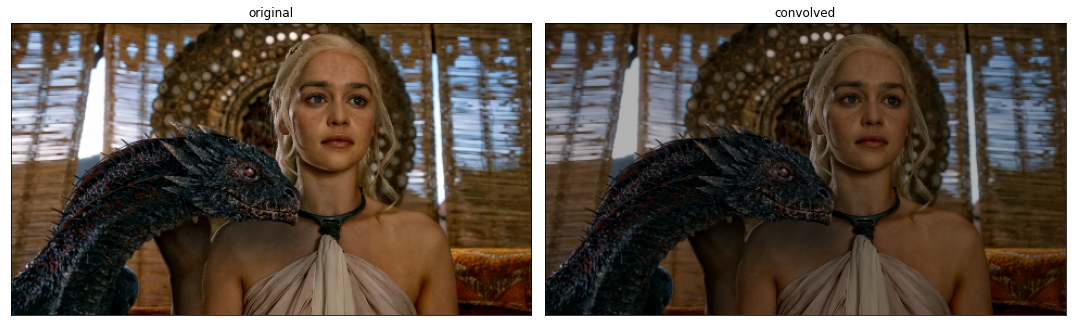

In [ ]:
kernel = np.zeros((3, 3))
kernel[1, 1] = 0.7
dst = cv2.filter2D(img, kernel=kernel, ddepth=-1)

show_multiple_images({'original': img, 'convolved': dst})

В первой домашке мы видели, что для свёртки можно использовать функцию `scipy.signal.correlate2d`. Напрямую мы её сейчас использовать не можем, потому что изображение стало трёхмерным. Мы можем использовать более общую функцию `scipy.signal.correlate`, но по сравнению с `cv2.filter2D` понадобится указать больше параметров, а также привести типы вручную:

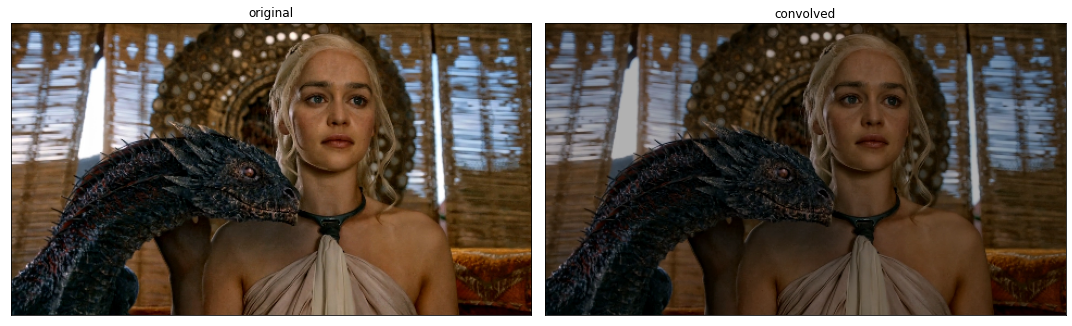

In [ ]:
import scipy.signal
dst = scipy.signal.correlate(img, kernel[:, :, np.newaxis], mode='valid').astype(np.uint8)

show_multiple_images({'original': img, 'convolved': dst})

Кстати, обратите внимание: на лекции мы говорили, что при свёртке цветной картинки ядро должно быть трёхмерным, но здесь это не так. Подумайте, что тут происходит. Подсказка содержится в аргументах функции `scipy.signal.correlate`.

Попробуем размыть изображение. В этом нам поможет следующее ядро размера $3 \times 3$:

$$ K = \frac 1 9 \cdot \begin{pmatrix}
1 & 1 & 1  \\
1 & 1 & 1  \\
1 & 1 & 1  \\
\end{pmatrix} $$

<!--$$ K = \frac{1}{n^2} \cdot \begin{pmatrix}
1 & 1 & \cdots & 1  \\
1 & 1 & \cdots & 1  \\
\vdots & \vdots & \ddots & \vdots \\
1 & 1 & \cdots & 1  \\
\end{pmatrix} $$-->

Оно берёт пиксель в центре каждого квадрата размера $3 \times 3$ и заменяет его на арифметическое среднее всех пикселей. Таким образом чёткость картинки уменьшается.

In [ ]:
img.shape

(270, 480, 3)

In [ ]:
dst.shape

(270, 480, 3)

In [ ]:
show_image(cv2.filter2D(cv2.resize(img, (48, 27), interpolation=cv2.INTER_CUBIC), kernel=kernel, ddepth=-1))

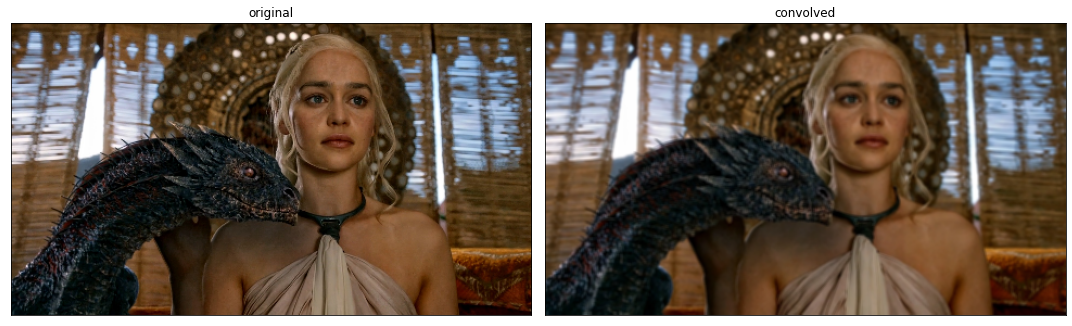

In [ ]:
kernel = np.full((3, 3), 1/9)
dst = cv2.filter2D(img, kernel=kernel, ddepth=-1)
cv2.filter2D()

show_multiple_images({'original': img, 'convolved': dst})

Ядро для увеличения чёткости. Обратите внимание на относительно большое значение якоря.

$$ \frac 1 9 \cdot \begin{pmatrix}
-1 & -1 & -1  \\
-1 & 17 & -1 \\         
-1 & -1 & -1 
\end{pmatrix} $$

Почему значение якоря именно такое, а не, скажем, 15 или 20?

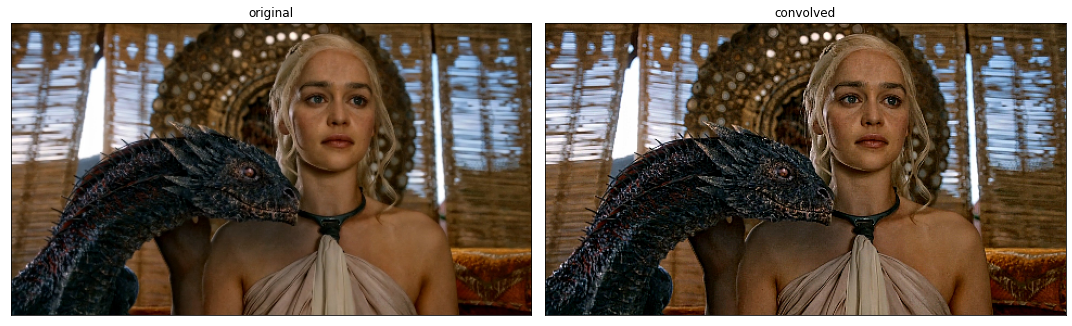

In [ ]:
kernel = np.full((3, 3), -1, dtype=np.float32)
kernel[1, 1] = 17
kernel /= 9
dst = cv2.filter2D(img, kernel=kernel, ddepth=-1)

show_multiple_images({'original': img, 'convolved': dst})

Забавно, что при повторном применении фильтра для увеличения чёткости, картинка покрывается шумом.

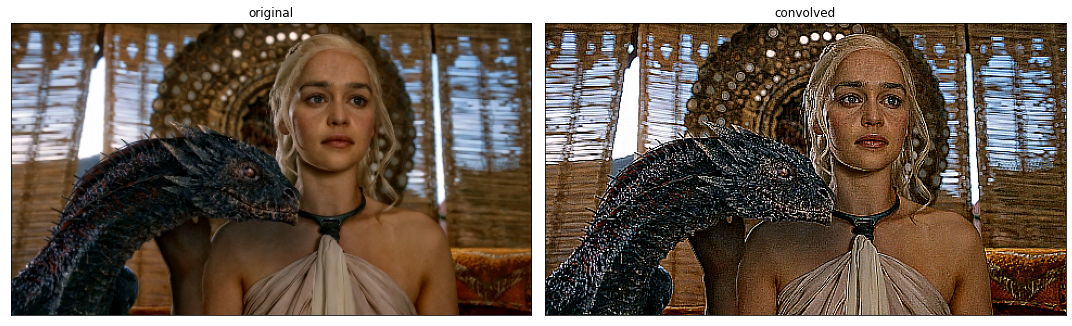

In [ ]:
dst = cv2.filter2D(img, kernel=kernel, ddepth=-1)
for _ in range(2):
    dst = cv2.filter2D(dst, kernel=kernel, ddepth=-1)

show_multiple_images({'original': img, 'convolved': dst})

Есть ещё один фильтр для сглаживания — gaussian blur. По-русски он обычно называется гауссовским. Строится он так. Сначала определяется одномерный фильтр как значения плотности нормального распределения:

$$
G_i = \alpha *e^{-\frac{(i-( \texttt{ksize} -1)/2)^2} {2 \cdot \texttt{sigma}^2}}
$$



In [ ]:
# sigma=0 означает, что библиотека сама выберет такую sigma, которую считает правильной.
# В документации можно найти формулу sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
gauss1d = cv2.getGaussianKernel(ksize=5, sigma=0)
gauss1d

array([[0.0625],
       [0.25  ],
       [0.375 ],
       [0.25  ],
       [0.0625]])

Потом из него строится двумерный фильтр банальным произведением столбца на строку:


In [ ]:
kernel = gauss1d @ gauss1d.T
kernel

array([[0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.0234375 , 0.09375   , 0.140625  , 0.09375   , 0.0234375 ],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625]])

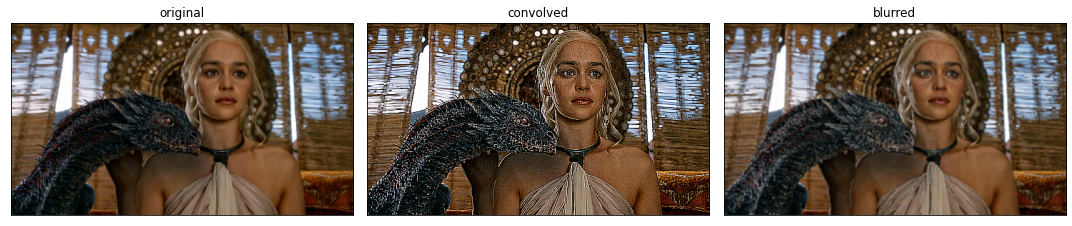

In [ ]:
blur = cv2.filter2D(dst, kernel=kernel, ddepth=-1)
show_multiple_images({'original': img, 'convolved': dst, 'blurred': blur})

Это настолько часто используемый фильтр, что для него в OpenCV даже выделили отдельную функцию:

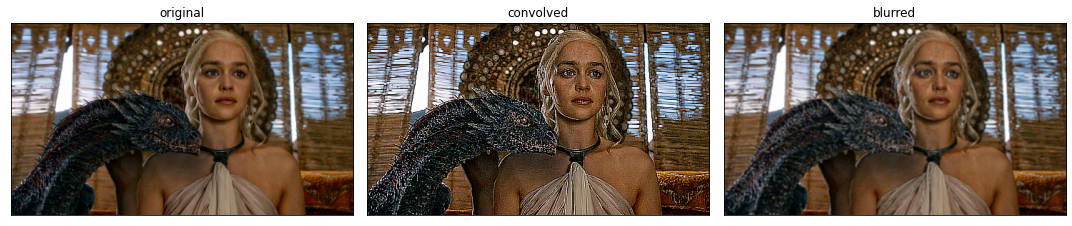

In [ ]:
blur = cv2.GaussianBlur(dst, (5, 5), 0)
show_multiple_images({'original': img, 'convolved': dst, 'blurred': blur})

Ядра бывают очень разными. Например:

* С таким ядром яркость изображения увеличится (почему?):

$$ \begin{pmatrix}
-0.1 & 0.2 & -0.1  \\
0.2 & 3 & 0.2 \\         
-0.1 & 0.2 & -0.1 
\end{pmatrix} $$

* С таким уменьшится (почему?):

$$ \begin{pmatrix}
-0.1 & 0.1 & -0.1  \\
 0.1 & 0.5 & 0.1 \\         
-0.1 & 0.1 & -0.1 
\end{pmatrix} $$

* С таким изображение почти не изменится (почему? почему "почти"?):

$$ \begin{pmatrix}
0 & 0 & 0  \\
0 & 1 & 0 \\         
0 & 0 & 0 
\end{pmatrix} $$

При хорошем знании линала, вы можете придумать самые безумные ядра. Попробуйте! 

In [ ]:
# Ваш код для игры в фильтры 

## 3. Углубляемся в свёртку

Попробуйте угадать, что делают следующие два фильтра. 

$$ \begin{pmatrix}
-1 & -1 & -1  \\
0 & 0 & 0 \\         
1 & 1 & 1 
\end{pmatrix}  $$

$$ \begin{pmatrix}
-1 & 0 & 1  \\
-1 & 0 & 1 \\         
-1 & 0 & 1 
\end{pmatrix} $$

Внимание, ответ. Первый фильтр пытается понять насколько резко изменяется яркость картинки по вертикали и находит вертикальные границы. Второй фильтр пытается понять насколько резко изменяется картинка по горизонтали и находит горизонтальные границы. Если просуммировать применение этих фильтров, можно получить чёткое очертание границ картинки. Чем больше в матрицах цифры, тем более резкую разницу находят ядра. 

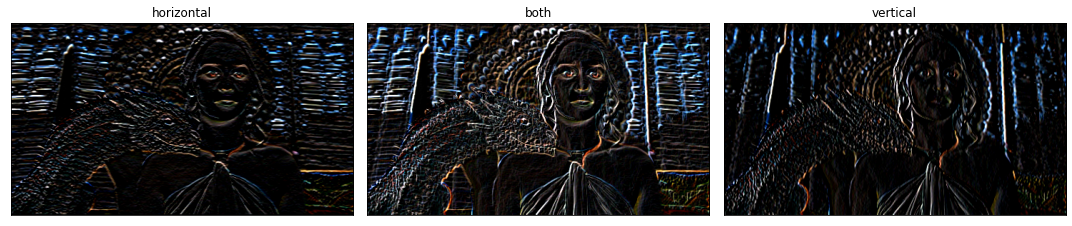

In [ ]:
kernel1 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
], dtype=np.float32)
kernel2 = kernel1.T
dst_h = cv2.filter2D(img, kernel=kernel1, ddepth=-1)
dst_v = cv2.filter2D(img, kernel=kernel2, ddepth=-1)
both = cv2.add(dst_h, dst_v)  # складываем две картинки, при переполнении np.uint8 останавливаемся на 0 или 255

show_multiple_images({'horizontal': dst_h, 'both': both, 'vertical': dst_v})

Если сначала обработать картинку ядром для повышения чёткости, потом заблюрить и наконец применить фильтр для поиска границ, они детектируются немного лучше.

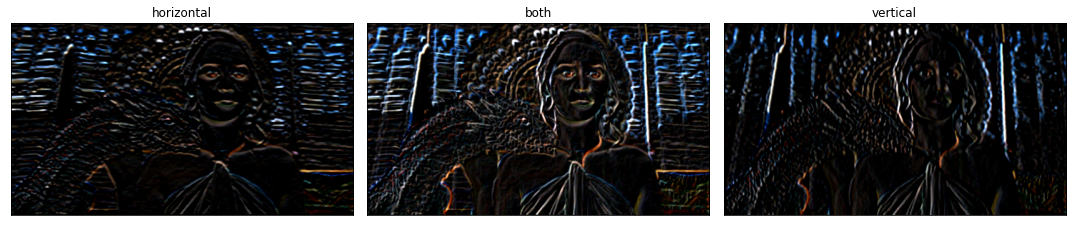

In [ ]:
kernel = np.full((3, 3), -1, dtype=np.float32)
kernel[1, 1] = 17
kernel /= 9
dst = cv2.filter2D(img, kernel=kernel, ddepth=-1)
dst = cv2.GaussianBlur(dst, (5, 5), 0)

kernel1 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
], dtype=np.float32)
kernel2 = kernel1.T
dst_h = cv2.filter2D(dst, kernel=kernel1, ddepth=-1)
dst_v = cv2.filter2D(dst, kernel=kernel2, ddepth=-1)
both = cv2.add(dst_h, dst_v)  # складываем две картинки, при переполнении np.uint8 останавливаемся на 0 или 255

show_multiple_images({'horizontal': dst_h, 'both': both, 'vertical': dst_v})

Внутри пакета есть своя функция для выделения границы. Она работает более агрессивно, чем наше ядро.

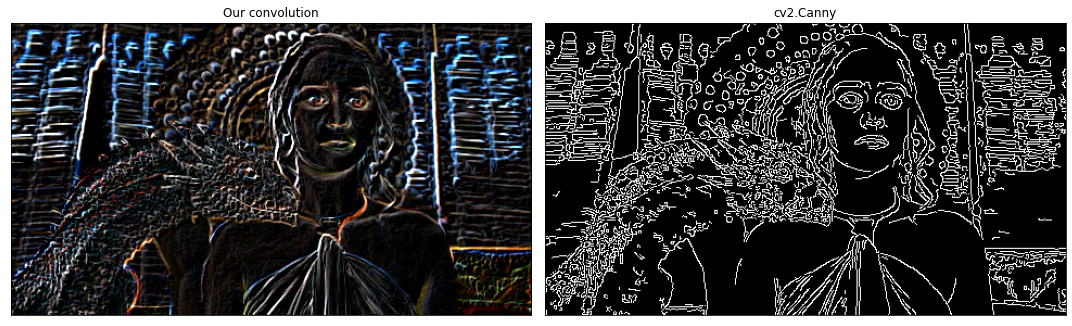

In [ ]:
kernel1 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
], dtype=np.float32)
kernel2 = kernel1.T
dst_h = cv2.filter2D(img, kernel=kernel1, ddepth=-1)
dst_v = cv2.filter2D(img, kernel=kernel2, ddepth=-1)
both = cv2.add(dst_h, dst_v)

# Функция из OpenCV. Числа — это некоторые параметры алгоритма, мы не будем в это углубляться
opencv_edges = cv2.Canny(img, 100, 200)

show_multiple_images({'Our convolution': both, 'cv2.Canny': opencv_edges})

Вообще, ядро поиска границы задаёт градиент картики по диагонали и градиент по вертикали. Можно побаловаться с более крутыми градиентами, в том числе диагональными.

$$ \begin{pmatrix}
0 & 1 & 2  \\
-1 & 0 & 1 \\         
-2 & -1 & 0 
\end{pmatrix} $$

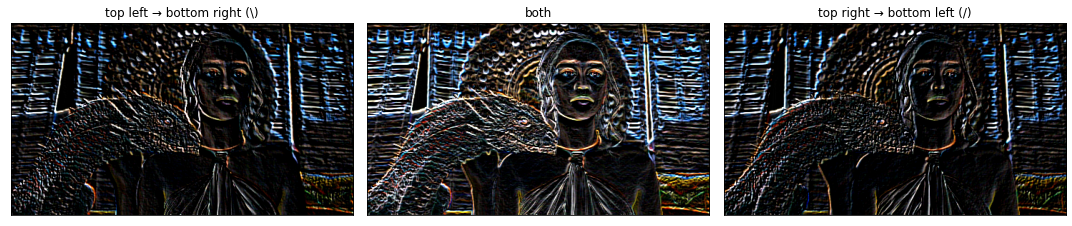

In [ ]:
kernel1 = np.array([
    [0, 1, 2],
    [-1, 0, 1],
    [-2, -1, 0],
], dtype=np.float32)
kernel2 = np.array([
    [2, 1, 0],
    [1, 0, -1],
    [0, -1, -2],
], dtype=np.float32)
dst_h = cv2.filter2D(img, kernel=kernel1, ddepth=-1)
dst_v = cv2.filter2D(img, kernel=kernel2, ddepth=-1)
both = cv2.add(dst_h, dst_v)

show_multiple_images({'top left → bottom right (\\)': dst_h, 'both': both, 'top right → bottom left (/)': dst_v})

Как вы уже догадались, можно придумать фильры не только для поиска границ, но и для поиска других различных закономерностей, которые есть на картинке. 

Представим себе на секунду славный дивный мир, в котором бывают картинки только двух типов: с прямыми слэшами и с обратными (/ \). При этом, эти слэши могут быть нарисованы на картинке где угодно. Пусть у нас есть две картинки. На одной из них слэш нарисован внизу справа, на второй сверху слева. Пройдёмся по нашим картинкам специальным ядром, которое ищет обратные слэши. После свёртки, мы получим на выходе две уменьшившиеся в размерах картинки, в каждой из которых будет фигурировать цифра два, как раз отвечающая за найденный обратный слэш.

<img align="center" src="https://github.com/FUlyankin/neural_nets_dpo/raw/e296fc12d4b3a7c523728feec5f56c59b6b35633/week08_conv/photo_1.png" width="600"> 

Если точно такое же ядро натравить на картинку без обратного слэша, оно не выдаст нам на выход никакой двойки. 

<img align="center" src="https://github.com/FUlyankin/neural_nets_dpo/raw/e296fc12d4b3a7c523728feec5f56c59b6b35633/week08_conv/photo_2.png" width="600"> 

Получаем простейший классификатор картинок с слэшами. 

1. Проходимся по картинке ядром. 
2. Находим в итоговой матрице максимальный элемент.
3. Если это двойка, на картинке изображён слэш. Если это единица, на картинке обратный слэш.

Обратите внимание, что работа этого классификатора не зависит от того, где именно на картинке находится слэш. Именно так свёрточные нейронные сети и работают с картинками. Конечно же, в реальности закономерности на картинках на порядок сложнее. При этом, мы даже не знаем какими именно могут быть эти закономерности. Для того, чтобы их искать, в нейронную сетку добавляются ядра с неспецифицированными параметрами.

$$ \begin{pmatrix}
w_1 & w_2 & w_3  \\
w_4 & w_5 & w_6 \\         
w_7 & w_8 & w_9 
\end{pmatrix} $$

Слои, на которых находятся эти ядра называются свёрточными. Параметры подбираются в ходе обучения нейронной сети по реальным данным и отражают в себе какие-то закономерности, найденные во время обучения на картинках. Представим, что наша нейронная сеть должна уметь распознавать лица. Добавим в неё несколько свёрточных слоёв. 

Первый слой будет находить простейшие элементы, такие как слэши, прямые чёрточки и извилистые чёрточки. Второй слой будет конструировать из элементов, найденных на первом слое, ещё более сложные штуки. В данном случае окружности и крестики. Третий слой будет конструировать из объектов, найденных на втором слое ещё более сложные объекты. Таким образом, мы, слой за слоем, будем собирать всё более и более сложные объекты до тех пор, пока не дойдём до лица. 

<img align="center" src="https://github.com/FUlyankin/neural_nets_dpo/raw/e296fc12d4b3a7c523728feec5f56c59b6b35633/week08_conv/photo_3.png" width="600"> 

Обычно закономерности, которые находит свёрточная сеть сложно интерпретируемы. Тем не менее, мы можем забрать те закономерности, которые нашла нейросетка и использовать их в качестве регрессоров в какой-то более интерпретируемой модели.

# 4. Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [CIFAR-10](https://paperswithcode.com/sota/image-classification-on-cifar-10). Набор данных включает в себя цветные изображения из 10 различных классов.

<img src="https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg" width="600">

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm.notebook import tqdm

## 4.1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ ($50 000$ для обучения, $10 000$ для валидации) цветных картинок размера $32 \times 32$.

In [ ]:
from pathlib import Path
from torch.hub import _get_torch_home

# На Linux датасет скачается в ~/.cache/torch/datasets, но можете выбрать любую другую папку
datasets_path = Path(_get_torch_home()) / 'datasets'

dataset_train = torchvision.datasets.CIFAR10(
    datasets_path, train=True, download=True,
    transform=torchvision.transforms.ToTensor()
)
dataset_valid = torchvision.datasets.CIFAR10(
    datasets_path, train=False, download=True,
    transform=torchvision.transforms.ToTensor()
)

class_idx_to_name = (
    'airplane', 'automobile', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse',
    'ship', 'truck',
)

Нарисуем несколько рандомных картинок из тренировочной выборки. 

In [ ]:
plt.figure(figsize=(16, 10))
n = 10
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(dataset_train[i][0].numpy().transpose(1, 2, 0))
    plt.title(class_idx_to_name[dataset_train[i][1]])
    plt.xticks([])
    plt.yticks([])
plt.show()

Заранее создадим даталоадеры:

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size)

## 4.2. Полносвязная сетка 

Соберём полносвязную сетку по аналогии с тем, что мы делали в прошлый раз:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
model = <YOUR CODE>
# Не забудьте перенести модель на GPU!
model

Кстати, заодно посмотрим на библиотеку `torchsummary`, позволяющую красиво печатать модель:

In [ ]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

In [ ]:
from torchsummary import summary
summary(model, (3 * 32 * 32,))  # на вход надо передать шейп входа модели, не считая размерности батча

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]         307,300
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 10]           1,010
Total params: 308,310
Trainable params: 308,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.18
Estimated Total Size (MB): 1.19
----------------------------------------------------------------


Зафиксируем параметры обучения:

In [ ]:
num_epochs = 20
batch_size = 500
learning_rate = 0.01

Заведём `criterion`, `opt`...

In [ ]:
criterion = <YOUR CODE>

In [ ]:
opt = <YOUR CODE>

Функция для обучения. Ничего необычного:

In [ ]:
def train(model, criterion, opt, train_dataloader, valid_dataloader, device='cuda:0', flatten=False):
    history = {'loss_train': [], 'loss_valid': [], 'accuracy_valid': [], 'lr': []}
    
    with tqdm(range(1, num_epochs + 1)) as progress_bar:
        for epoch in progress_bar:
            epoch_losses_train = []
            epoch_losses_valid = []
            epoch_accuracies_valid = []
            
            # Трейн
            for x_batch, y_batch in train_dataloader:
                if flatten:
                    x_batch = x_batch.reshape(x_batch.shape[0], -1)

                # Переносим батч на GPU
                x_batch = <YOUR CODE>
                y_batch = <YOUR CODE>

                y_pred = <YOUR CODE>  # делаем предсказания
                loss = <YOUR CODE>  # считаем лосс
                
                epoch_losses_train.append(loss.item())
                assert np.isfinite(epoch_losses_train[-1])

                # Считаем градиенты и делаем шаг оптимизатора, не забыв обнулить градиенты
                <YOUR CODE>

            with torch.no_grad():
                for x_batch, y_batch in valid_dataloader:
                    if flatten:
                        x_batch = x_batch.reshape(x_batch.shape[0], -1)

                    # Переносим батч на GPU
                    x_batch = <YOUR CODE>
                    y_batch = <YOUR CODE>

                    y_pred = <YOUR CODE> # делаем предсказания
                    loss = <YOUR CODE> # считаем лосс
                    
                    epoch_losses_valid.append(loss.item())
                    assert np.isfinite(epoch_losses_valid[-1])

                    epoch_accuracies_valid.extend((torch.argmax(y_pred, dim=-1) == y_batch).to('cpu').numpy().tolist())
                    
            history['loss_train'].append(np.mean(epoch_losses_train))
            history['loss_valid'].append(np.mean(epoch_losses_valid))
            history['accuracy_valid'].append(np.mean(epoch_accuracies_valid))
            history['lr'].append(opt.param_groups[0]['lr'])

            # выводим статистику
            stats = f'loss: {history["loss_valid"][-1]:.5f}, accuracy: {history["accuracy_valid"][-1]:.4f}'
            print(f'Epoch: {epoch}, {stats}')
            progress_bar.set_postfix_str(stats)
            
    return history

Вспомогательная функция, чтобы рисовать графики:

In [ ]:
def plot_history(histories):
    plt.figure(figsize=(16, 10))

    for name, history in histories.items():
        train = plt.plot(history['loss_train'], label=f'{name} train')
        plt.plot(history['loss_valid'], color=train[0].get_color(), linestyle='--', label=f'{name} valid')

    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.legend()
    plt.grid()

histories = {}

Учим бейзлайн:

In [ ]:
histories['fc'] = <YOUR CODE>

In [ ]:
plot_history(histories)

## 4.3. Свёрточная сетка 

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) — Свёртка:
    - **in_channels**: число каналов на входе;
    - **out_channels**: число каналов на выходе; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: какой ширины будет каёмка из нулей по краям картинки перед непосредственно свёрткой (если хотите, чтобы свёртка не меняла размер картинки, ставьте `padding=(kernel_size - 1) // 2`)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) — max-pooling
* [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) — average pooling
* [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html) — разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) — полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) — функция активации. Естественно, можно выбрать любую другую


В модели, которую мы определим ниже, на вход будут тензоры размера `(B, 1, 32, 32)`, а на выходе `(B, 10)` — это будет вероятность того, что объект относится к конкретному классу. `B`, как обычно, означает размерность батча. 

Теперь давайте соберём свёрточную сеть наподобие LeNet-5: 

* Свёртка с $3$ каналами на входе (для цветного изображения), $32$ каналами на выходе, ядром $5 \times 5$ и `padding` таким, чтобы размер изображения не менялся
* ReLU
* Max-pooling с ядром $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с $16$ каналами на выходе, ядром $5 \times 5$ и `padding` таким, чтобы размер изображения не менялся
* ReLU
* Max-pooling с ядром $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $60$ нейронами

Это не то же самое, что оригинальный LeNet-5. Если вы заглянете в [оригинальную статью](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), то увидите там очень читабельное описание архитектуры, которая на современный взгляд выглядит странно.

Реализацию оригинальной архитектуры на PyTorch можно посмотреть, например, [тут](https://github.com/maorshutman/lenet5-pytorch).

In [ ]:
model = <YOUR CODE>
# Не забудьте перенести модель на GPU!
model

In [ ]:
summary(model, (3, 32, 32))

In [ ]:
opt = <YOUR CODE>

In [ ]:
histories['conv'] = <YOUR CODE>

In [ ]:
plot_history(histories)

Как видите, точность довольно сильно подскочила. Попробуйте поиграться числом параметров и слоёв так, чтобы их стало меньше, а качество сетки стало лучше. Попробуйте обучать нейросетку большее количество эпох.

In [ ]:
# Здесь могли быть ваши эксперименты